<a href="https://colab.research.google.com/github/josooik/DeepLearning/blob/main/2021_11_01_detertor_with_mask.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [169]:
! git clone https://github.com/josooik/Face-detection-for-DSM

fatal: destination path 'Face-detection-for-DSM' already exists and is not an empty directory.


In [170]:
import cv2, sys
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

### Detect_Flow()

In [171]:
def detect_flow(imgPath, modelDir):
    
    # read image
    img = cv2.imread(imgPath)
    (img_h, img_w) = img.shape[:2]
    print("* org img shape:", imgPath,  img.shape)
    
    # use model
    facenet = cv2.dnn.readNet(modelDir+"/deploy.prototxt",
                              modelDir+"/res10_300x300_ssd_iter_140000.caffemodel")
    
    blob = cv2.dnn.blobFromImage(img, 
                                 1.0, (300, 300),
    	                          (104.0, 177.0, 123.0))
    facenet.setInput(blob)
    detections = facenet.forward()
    print("* dections results:", detections.shape)
   
    # get results from detections
    faces = []
    for i in range(detections.shape[2]):
      conf = detections[0,0,i,2]
      if conf <0.5:
        continue
      x1 = int(detections[0,0,i,3]*img_w)
      y1 = int(detections[0,0,i,4]*img_h)
      x2 = int(detections[0,0,i,5]*img_w)
      y2 = int(detections[0,0,i,6]*img_h)
      #cv2.rectangle(img, (x1, y1), (x2, y2), (0,255,0), 2)

      # 얼굴만 크롭하기
      face = img[y1:y2, x1:x2]
      faces.append(face)

      return faces, x1, y1, x2, y2

In [172]:
imgPath = 'Face-detection-for-DSM/imgs/mask_face.jpg'
modelDir = 'Face-detection-for-DSM/models'
faces, x1, y1, x2, y2 = detect_flow(imgPath, modelDir)

* org img shape: Face-detection-for-DSM/imgs/mask_face.jpg (417, 626, 3)
* dections results: (1, 1, 200, 7)


(221, 147, 3)


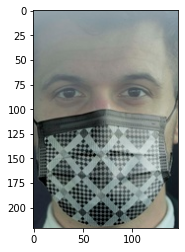

In [173]:
for face in faces:
  print(face.shape)
  plt.imshow(cv2.cvtColor(face, cv2.COLOR_BGR2RGB))

plt.show()

In [174]:
from tensorflow.keras import applications, utils, layers, models, optimizers

In [175]:
faces_pre = []

for face in faces:
  face = cv2.resize(face, (224, 224))
  face = applications.mobilenet_v2.preprocess_input(face)
  faces_pre.append(face)
  print(face.shape)

(224, 224, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(224, 224, 3)


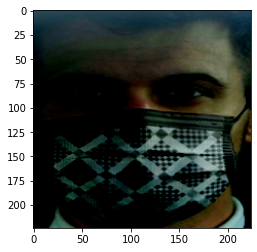

In [176]:
for face in faces_pre:
  print(face.shape)
  plt.imshow(cv2.cvtColor(face, cv2.COLOR_BGR2RGB))

plt.show()

In [177]:
from tensorflow.keras import models

model_cfy = models.load_model("Face-detection-for-DSM/models/mask_model.h5")

In [178]:
faces_pre = np.array(faces_pre)
faces_pre.shape

(1, 224, 224, 3)

In [179]:
results = model_cfy.predict(faces_pre)

print("faces_pre_predict = ", model_cfy.predict(faces_pre))

faces_pre_predict =  [[0.9587397  0.04126029]]


# Visualize

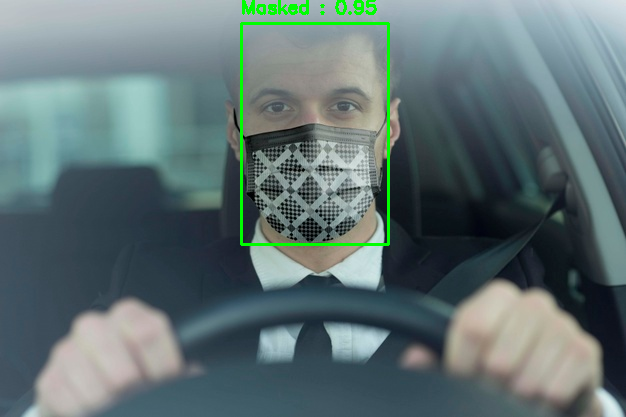

p_mask : 0.9587397
p_without_mask : 0.04126029


In [180]:
res_1 = results[0]
p_mask = res_1[0]
p_without_mask = res_1[1]

img = cv2.imread(imgPath)

if p_mask > p_without_mask:
  color = (0, 255, 0)
  label = "Masked" + " : " + str(p_mask)[:4]

else:
  color = (0, 0, 255)
  label = "Without Mask" + " : " + str(p_without_mask)[:4]

cv2.putText(img, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
cv2_imshow(img)

print("p_mask :", p_mask)
print("p_without_mask :", p_without_mask)
